# Problème 1 : Hexapode

In [2]:
from brian2 import *
%matplotlib inline

C:\Users\asus\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
INFO       Cache size for target "cython": 3843 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\asus\.cython\brian_extensions" directory. [brian2]


## Définition des pattes (neurones moteurs + neurones connecteurs)
Chaque patte comprend:
Trois neurones moteurs comme suit : 
* 0 : mouvement avant
* 1 : mouvement élevation de la patte
* 2 : mouvement arrière

Deux neurones connecteurs sont comme suit:
* 0 : connecteur pour la commande avant
* 1 : connecteur pour la commande arrière

La disposition des pattes est la suivante:
```
  \__/
0_|  |_1
2_|  |_3
4_|__|_5
```

In [3]:
# 1----------------------------------------------Définition équations des neurones
start_scope()

eqsMoteur = '''
dv/dt = ((s*int(v > 0 or s>0)) - v)/tau  : 1
tau = 10*ms : second
ds/dt = -s/(tau*2) : 1
'''
resetMoteur = '''
v=0
s=s*int(s>1.8)
'''
eqsConnecteur = '''
dv/dt = - v/tau  : 1
tau = 10*ms : second
'''
wiMoteur = 1 #Poids de la synapse inhibitrice inter-commande
wiConnMoteur = 1.8 #Poids de la synapse excitatrice connecteur-moteur


# 2----------------------------------------------Création des groupes de neurones et des synapses
pattes = []
nombrePattes = 6
neuronesMoteur = NeuronGroup(3*nombrePattes, eqsMoteur, threshold='v>=0.9', reset=resetMoteur, method='euler')
neuronesConnecteur = NeuronGroup(2*nombrePattes, eqsConnecteur, threshold='v>=0.9', reset='v=0', method='exact')

for nb in range(nombrePattes):
    neuroneMoteur = neuronesMoteur[3*nb:3*nb+3]
    #Synapse inhibitrice entre le moteur avant (0) et le moteur arrière (2)
    SynMoteur = Synapses(neuroneMoteur, neuroneMoteur, on_pre='s -= wiMoteur')
    SynMoteur.connect(i=0, j=2)
    SynMoteur.connect(i=2, j=0)
    statemonMoteur = StateMonitor(neuroneMoteur, ['v', 's'], record=True)
    spikemonMoteur = SpikeMonitor(neuroneMoteur)

    neuroneConnecteur = neuronesConnecteur[2*nb:2*nb+2]
    #Synapse exitatrice entre neurones connecteurs et neurones moteurs
    SynConnMoteur = Synapses(neuroneConnecteur, neuroneMoteur, on_pre='s += wiConnMoteur*(0.5+0.5*int(s<=0))')
    SynConnMoteur.connect(i=0, j=[0,1])
    SynConnMoteur.connect(i=1, j=[1,2])
    #statemonConnecteur = StateMonitor(neuroneConnecteur, 'v', record=True)
    spikemonConnecteur = SpikeMonitor(neuroneConnecteur)
    
    patte = {
        "neuroneMoteur": neuroneMoteur,
        "SynMoteur": SynMoteur,
        "statemonMoteur": statemonMoteur,
        "spikemonMoteur": spikemonMoteur,
        "neuroneConnecteur": neuroneConnecteur,
        "SynConnMoteur": SynConnMoteur,
        #"statemonConnecteur": statemonConnecteur,
        "spikemonConnecteur": spikemonConnecteur,        
    }
    pattes.append(patte)


## Définition des neurones commandes
Il y'a 4 neurones commandes comme suit:
* 0 : neurone commande avant
* 1 : neurone commande arrière
* 2 : neurone commande droite
* 3 : neurone commande gauche

In [4]:
# 1---------------------------------------------- Définition des équations

eqsCommande = '''
dv/dt = ((s*int(v > 0 or s>0)) + I - v)/tau  : 1
tau : second
ds/dt = -s/tau : 1
I : 1
'''

# 2---------------------------------------------- Définition des neurones commande
neuroneCommande = NeuronGroup(4, eqsCommande, threshold='v>=0.9', reset='v=0', method='euler')
neuroneCommande.tau = 20*ms
statemonCommande = StateMonitor(neuroneCommande, ['v', 's'], record=True)
spikemonCommande = SpikeMonitor(neuroneCommande)
#Synapse inhibitrice entre neurones commande
wiCommande = 1 #Poids de la synapse inhibitrice
SynCommande = Synapses(neuroneCommande, neuroneCommande, on_pre='s -= wiCommande')
SynCommande.connect(i=0, j=1)
SynCommande.connect(i=1, j=0)
SynCommande.connect(i=2, j=3)
SynCommande.connect(i=3, j=2)

commandes = {
        "neuroneCommande": neuroneCommande,
        "statemonCommande": statemonCommande,
        "spikemonCommande": spikemonCommande,
    }


## Connexion entre neurones commande et pattes

In [5]:
SynapseCommandeConnect = []
for num, patte in enumerate(pattes):
    #Synapse excitatrice de neurone commande vers neurones connecteurs des pattes
    SynCommandeConnect = Synapses(commandes["neuroneCommande"], patte["neuroneConnecteur"], on_pre='v = 1')
    #SynCommandeConnect.connect(j='i')
    SynCommandeConnect.connect(i=0, j=0)
    SynCommandeConnect.connect(i=1, j=1)
    if num%2==0:
        SynCommandeConnect.connect(i=2, j=0)
    else:
        SynCommandeConnect.connect(i=3, j=0)
    SynCommandeConnect.delay[0:2,:] = 'num*15*ms'
    SynCommandeConnect.delay[2:4,0] = '(num*15+1)*ms'
    SynapseCommandeConnect.append(SynCommandeConnect)

## Exécution et visualisation


In [6]:
net = Network(collect())
net.add(pattes)
net.add(SynapseCommandeConnect)
net.store()

colors = ["blue", "orange", "red"]
markers = ['>', '.', '<']

def visualiser():
    figure(figsize=(20, 6))
    for num, patte in enumerate(pattes):
        spikemon = patte["spikemonMoteur"]
        for t,j in zip(spikemon.t, spikemon.i):
            plot(t/ms, num+1, markers[j], color=colors[j])
    spikemon = commandes["spikemonCommande"]        
    for t,i in zip(spikemon.t, spikemon.i):
        axvline(t/ms, ls='--', c='blue' if (i==0) else 'red')

def visualiserDetail(avant = True):
    figure(figsize=(20, 6))
    statemonCommande = commandes["statemonCommande"]
    plot(statemonCommande.t/ms, statemonCommande.v[0 if (avant) else 1], '--', label='VNeuronecom')
    for num, patte in enumerate(pattes[:2]):
        label = 'Patte - '+str(num)
        statemon = patte["statemonMoteur"]
        plot(statemon.t/ms, statemon.v[0 if (avant) else 2], label=label)
    xlabel('Time (ms)')
    ylabel('v')
    legend(loc='best');

### Déplacement avant

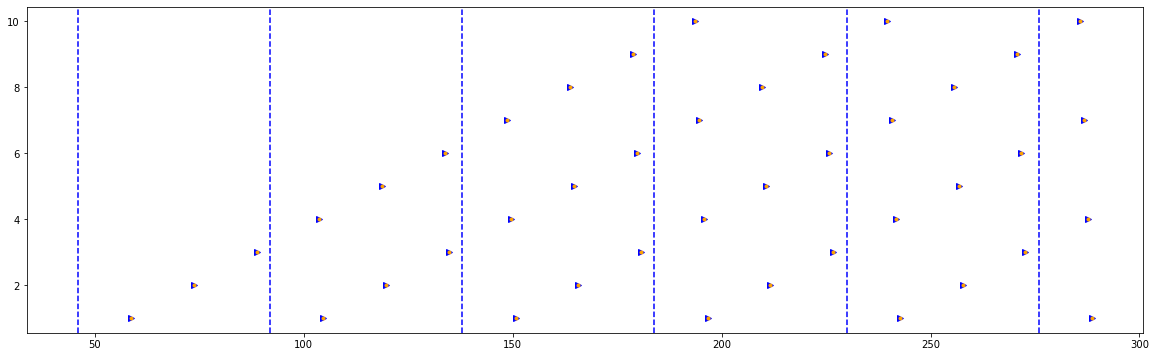

In [7]:
net.restore()
commandes["neuroneCommande"][0].I = 1
net.run(300*ms)

visualiser()

### Déplacement arrière

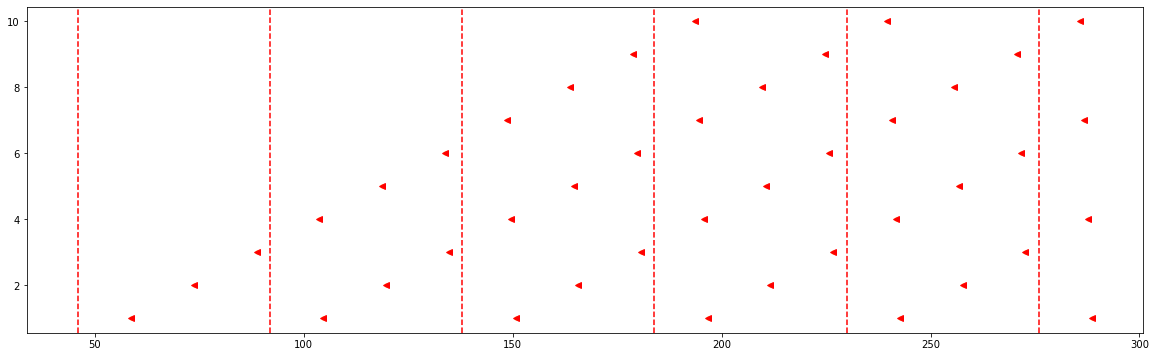

In [8]:
net.restore()
commandes["neuroneCommande"][1].I = 1
net.run(300*ms)

visualiser()

### déplacement avant accéléré

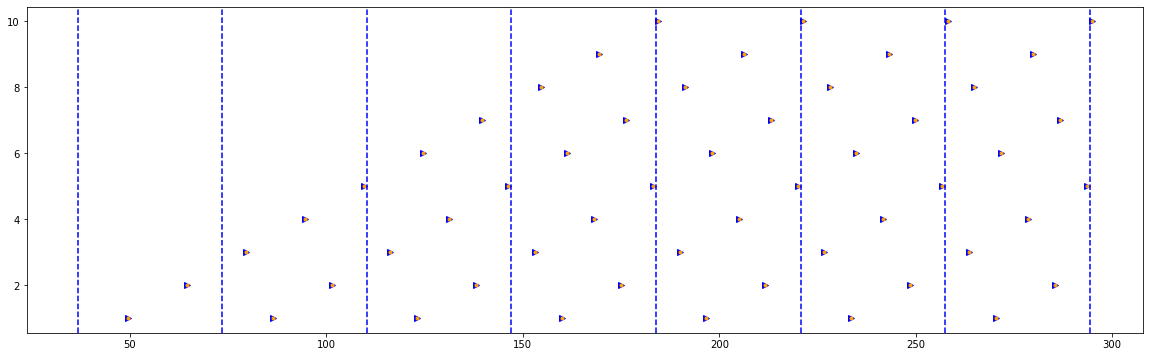

In [9]:
net.restore()
commandes["neuroneCommande"][0].I = 1
commandes["neuroneCommande"][0].tau = 16*ms
net.run(300*ms)

visualiser()

### déplacement avant & droite

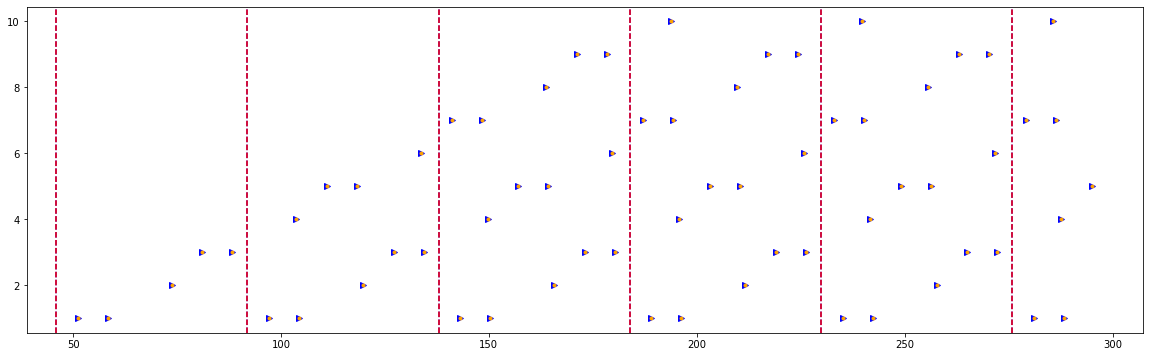

In [10]:
net.restore()
commandes["neuroneCommande"][0].I = 1
commandes["neuroneCommande"][2].I = 1
net.run(300*ms)

visualiser()

### déplacement avant & gauche

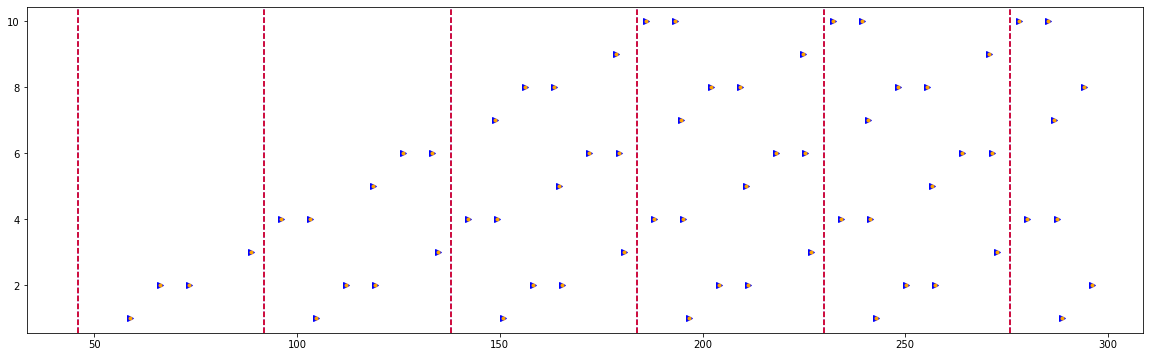

In [11]:
net.restore()
commandes["neuroneCommande"][0].I = 1
commandes["neuroneCommande"][3].I = 1
net.run(300*ms)

visualiser()

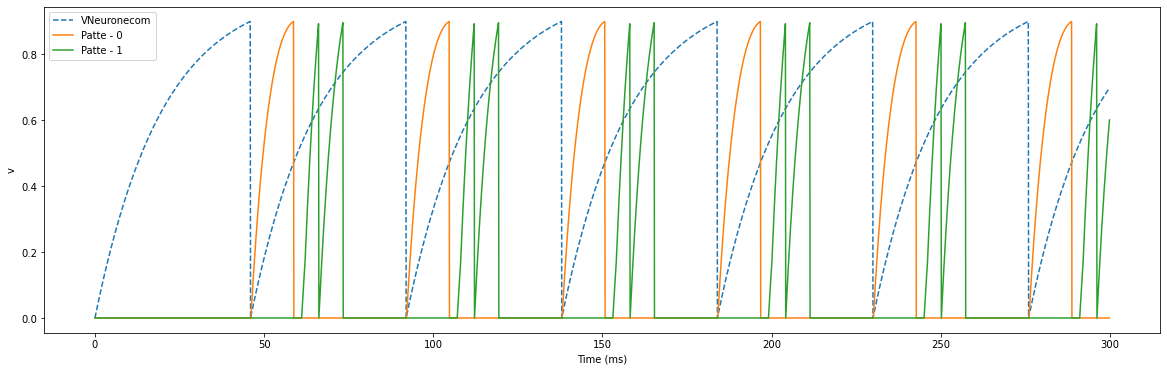

In [12]:
visualiserDetail()